# Bayesian Dynamic TWFE

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from patsy import dmatrix
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [2]:
filepath = '../../../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)

## Dynamic TWFE

$$
\begin{aligned}
Y_{it} = (\beta + r_{\beta}) * W_{it}  + \epsilon_{it} \\
\end{aligned}
$$

- $r_{\beta}$: 介入前後の経過時間

### ベイズモデル

In [45]:
time_since_treatment = dmatrix('C(time_since_treatment) - 1', data=df, return_type='dataframe')
time_since_treatment = time_since_treatment.drop(columns='C(time_since_treatment)[-48]')
unique_time_since_treatment = time_since_treatment.columns
len_unique_time_since_treatment = len(unique_time_since_treatment)

In [15]:
len_unique_time_since_treatment

120

/home/keisei/data-analysis/bridge-treatment-effects/.venv/lib/python3.12/site-packages/pymc/model/core.py:1302: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


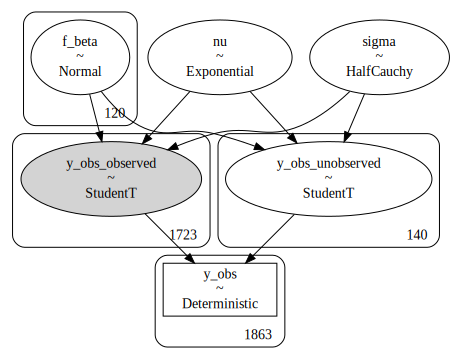

In [ ]:
COORDS = {'obs_id': df.index}

with pm.Model(coords=COORDS) as dynamic_twfe:
    # data
    # treatment = pm.Data('treatment', df['after_treatment'])
    # treatment_group = pm.Data('treatment_group', df['treatment_group'])

    # priors
    # random effect

    # fixed effect
    beta = pm.Normal('beta', mu=0, sigma=100, shape=len_unique_time_since_treatment)
    sigma = pm.HalfCauchy('sigma', beta=100)
    nu = pm.Exponential('nu', lam=1/30)

    # expectation
    mu = pm.math.dot(time_since_treatment, beta)

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma, observed=df['log_pop_star'])

pm.model_to_graphviz(dynamic_twfe)

In [21]:
with dynamic_twfe:
    trace_dynamic_twfe = pm.sample(
        draws=1000,
        tune=1000,
        chains=4,
        cores=6,
        nuts_sampler='numpyro',
        random_seed=42
    )
    pm.compute_log_likelihood(trace_dynamic_twfe)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

In [25]:
az.summary(trace_dynamic_twfe, var_names=['f_beta', 'sigma', 'nu'], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
f_beta[0],-0.191,0.171,-0.506,0.175,0.016,0.011,124.0,230.0,1.02
f_beta[1],0.277,0.220,-0.172,0.745,0.043,0.036,39.0,33.0,1.13
f_beta[2],-15.320,113.114,-300.412,181.826,46.305,34.491,6.0,11.0,1.75
f_beta[3],-0.273,0.157,-0.577,0.011,0.018,0.012,79.0,316.0,1.06
f_beta[4],0.201,0.170,-0.157,0.558,0.016,0.011,117.0,105.0,1.03
...,...,...,...,...,...,...,...,...,...
f_beta[117],0.171,0.242,-0.282,0.667,0.034,0.024,50.0,94.0,1.07
f_beta[118],0.303,0.216,-0.149,0.801,0.044,0.031,24.0,67.0,1.16
f_beta[119],0.462,0.213,0.084,0.833,0.022,0.016,126.0,88.0,1.03
sigma,0.145,0.005,0.136,0.154,0.001,0.001,35.0,228.0,1.08


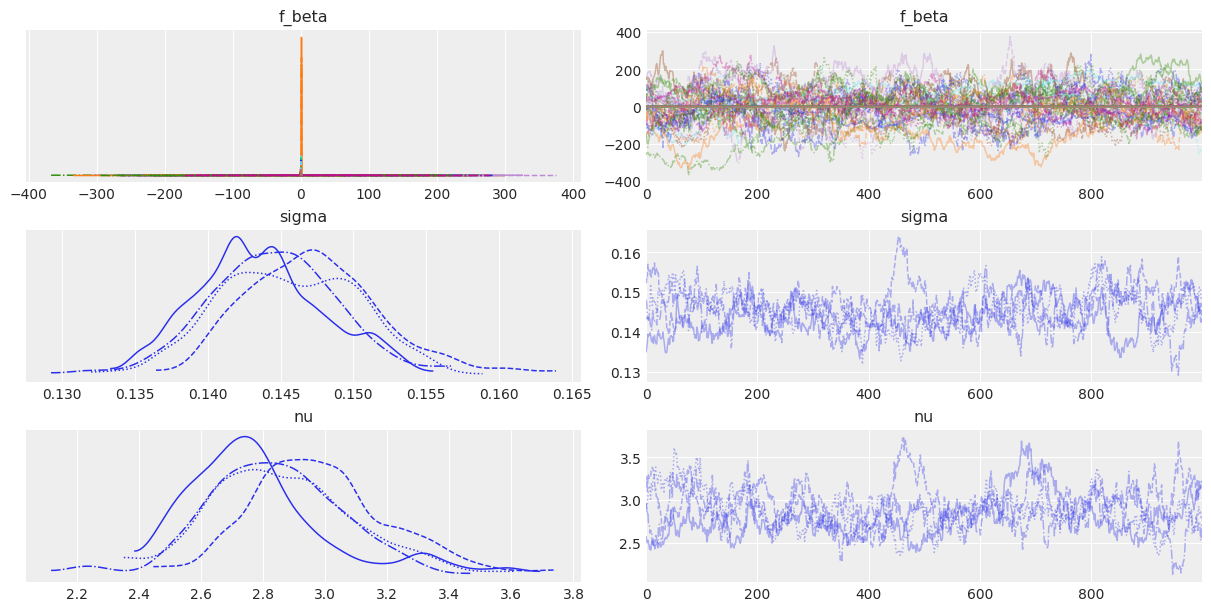

In [27]:
az.plot_trace(trace_dynamic_twfe, var_names=['f_beta', 'sigma', 'nu']);

In [28]:
az.waic(trace_dynamic_twfe)

/home/keisei/data-analysis/bridge-treatment-effects/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 1723 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   170.26    44.09
p_waic      122.07        -

There has been a warning during the calculation. Please check the results.

In [42]:
time_since_treatment.columns

Index(['C(time_since_treatment)[-46]', 'C(time_since_treatment)[-45]',
       'C(time_since_treatment)[-43]', 'C(time_since_treatment)[-41]',
       'C(time_since_treatment)[-40]', 'C(time_since_treatment)[-38]',
       'C(time_since_treatment)[-36]', 'C(time_since_treatment)[-35]',
       'C(time_since_treatment)[-34]', 'C(time_since_treatment)[-33]',
       ...
       'C(time_since_treatment)[86]', 'C(time_since_treatment)[91]',
       'C(time_since_treatment)[96]', 'C(time_since_treatment)[101]',
       'C(time_since_treatment)[106]', 'C(time_since_treatment)[111]',
       'C(time_since_treatment)[116]', 'C(time_since_treatment)[121]',
       'C(time_since_treatment)[126]', 'C(time_since_treatment)[131]'],
      dtype='object', length=120)

In [44]:
df['time_since_treatment'].unique()


array([-29, -24, -19, -14,  -9,  -4,   1,   6,  11,  16,  21, -45, -40,
       -35, -30, -25, -20, -15, -13, -12, -11, -10,  -8,  -7,  -6,  -5,
        -3,  -2,  -1,   0,   2,   3,   4,   5, -34,   7,   8,   9,  10,
        12,  13,  14,  15, -18,  17,  22,  27,  32,  26,  31,  19,  24,
        29,  34,  39,  44,  49,  54,  59,  64,  69,  37,  42,  47,  52,
       -21, -16, -17,  18,  20,  23,  25,  28,  30,  33, -22, -38, -33,
       -28, -23,  36,  41,  35,  40,  45, -27,  81,  86,  91,  96, 101,
       106, 111, 116, 121, 126, 131,  38,  43,  48,  50,  55,  60,  65,
        70,  75,  80,  85,  53,  58,  63,  68, -48, -43, -26, -41, -36,
       -31,  46,  51, -46])

In [69]:
# 数値を抽出する関数
def extract_number(text):
    match = re.search(r'\[-?\d+\]', text)
    if match:
        return int(match.group(0).strip('[]'))
    return None

def get_delta_df(trace):
    # ランダム効果のサマリーを取得
    f_beta_df = az.summary(trace, var_names=['f_beta'], hdi_prob=0.95, kind='stats')

    # 経過年数
    time_since_treatment_df = pd.DataFrame(unique_time_since_treatment, columns=['time_since_treatment_str'])
    time_since_treatment_df['time_since_treatment'] = time_since_treatment_df['time_since_treatment_str'].apply(extract_number)

    # ランダム効果の値を経過年数と結合
    # ランダム効果の順番は経過年数の昇順ではなく，データに登場した順番になっている．
    f_beta_df.reset_index(drop=True, inplace=True)
    f_beta_df = pd.concat([f_beta_df, time_since_treatment_df], axis=1)

    # 新しい列に数値を格納

    return f_beta_df

def plot_effects_over_time(f_beta_df):
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        x='time_since_treatment',
        y='mean',
        data=f_beta_df,
        marker='o',
        color='black',
        label='Mean'
    )
    # エラーバー
    plt.errorbar(
        x=f_beta_df['time_since_treatment'],
        y=f_beta_df['mean'],
        yerr=[
            f_beta_df['mean'] - f_beta_df['hdi_2.5%'],
            f_beta_df['hdi_97.5%'] - f_beta_df['mean']
        ],
        fmt='o',
        color='black',
        alpha=0.5,
        capsize=5,
        label='95% HDI'
    )
    plt.axvline(x=0, color='black', linestyle=':')
    plt.axhline(y=0, color='black', linestyle=':')
    plt.ylim(-0.75, 0.75)
    plt.xlabel('Time since Treatment')
    plt.ylabel('Effects')
    plt.title('Effects Over Time')
    plt.legend()
    plt.show()

In [72]:
delta_df

,mean,sd,hdi_2.5%,hdi_97.5%,time_since_treatment_str,time_since_treatment
0,-0.191,0.171,-0.506,0.175,C(time_since_treatment)[-46],-46
1,0.277,0.220,-0.172,0.745,C(time_since_treatment)[-45],-45
2,-15.320,113.114,-300.412,181.826,C(time_since_treatment)[-43],-43
3,-0.273,0.157,-0.577,0.011,C(time_since_treatment)[-41],-41
4,0.201,0.170,-0.157,0.558,C(time_since_treatment)[-40],-40
...,...,...,...,...,...,...
115,-0.016,0.191,-0.431,0.316,C(time_since_treatment)[111],111
116,0.099,0.186,-0.302,0.492,C(time_since_treatment)[116],116
117,0.171,0.242,-0.282,0.667,C(time_since_treatment)[121],121
118,0.303,0.216,-0.149,0.801,C(time_since_treatment)[126],126


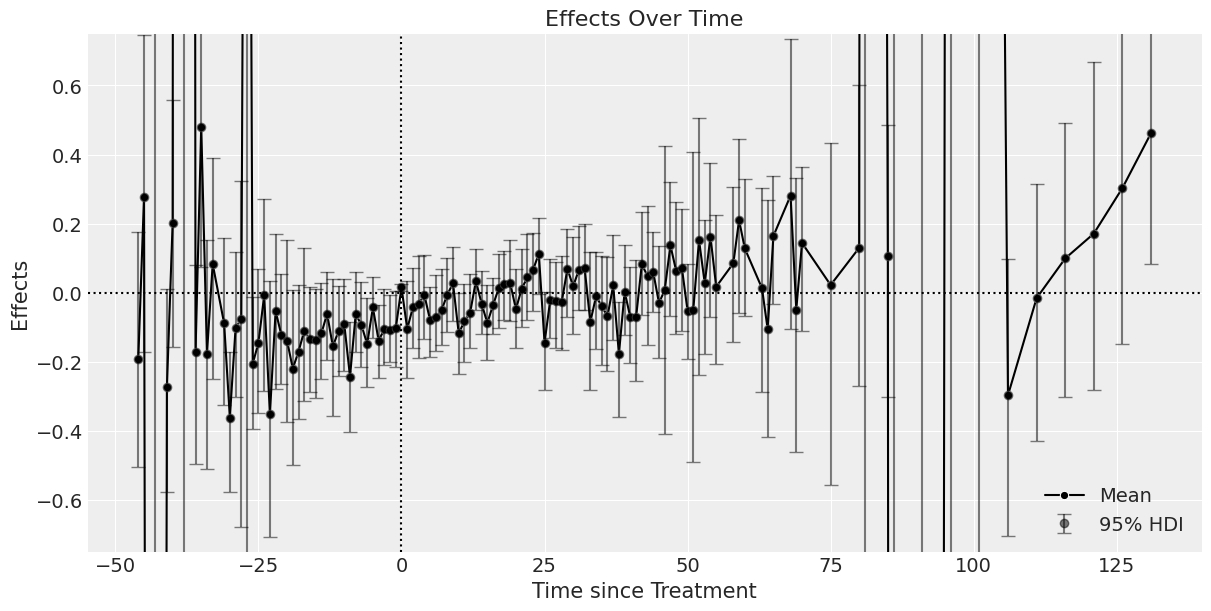

In [71]:
delta_df = get_delta_df(trace_dynamic_twfe)
plot_effects_over_time(delta_df)

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pymc/model/core.py:1359: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


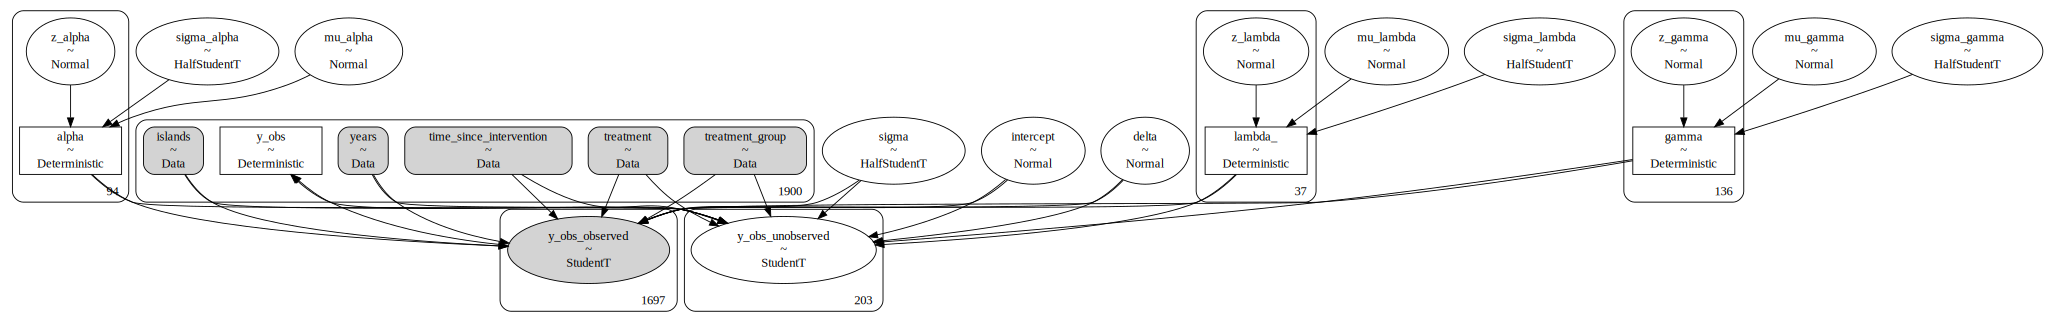

In [15]:
# 0から始まるインデックスを振り直す
df['island_ids'], unique_island_ids = pd.factorize(df['island_ids'])
df['years'], unique_years = pd.factorize(df['years'])

with pm.Model() as dynamic_twfe_h:
    # data
    islands = pm.Data('islands', df['island_ids'])
    years = pm.Data('years', df['years'])
    treatment = pm.Data('treatment', df['after_treated'])
    treatment_group = pm.Data('treatment_group', df['treatment_group'])
    time_since_intervention = pm.Data('time_since_intervention', df['time_since_intervention'])

    # priors
    # random effect
    mu_alpha = pm.Normal('mu_alpha', mu=0, sigma=100)
    sigma_alpha = pm.HalfStudentT('sigma_alpha', nu=3, sigma=100)
    z_alpha = pm.Normal('z_alpha', mu=0, sigma=1, shape=len(df['island_ids'].unique()))
    alpha = pm.Deterministic('alpha', mu_alpha + sigma_alpha * z_alpha)

    mu_lambda = pm.Normal('mu_lambda', mu=0, sigma=100)
    sigma_lambda = pm.HalfStudentT('sigma_lambda', nu=3, sigma=100)
    z_lambda = pm.Normal('z_lambda', mu=0, sigma=1, shape=len(df['years'].unique()))
    lambda_ = pm.Deterministic('lambda_', mu_lambda + sigma_lambda * z_lambda)

    mu_gamma = pm.Normal('mu_gamma', mu=0, sigma=100)
    sigma_gamma = pm.HalfStudentT('sigma_gamma', nu=3, sigma=100)
    z_gamma = pm.Normal('z_gamma', mu=0, sigma=1, shape=len(df['time_since_intervention'].unique()))
    gamma = pm.Deterministic('gamma', mu_gamma + sigma_gamma * z_gamma)

    # fixed effect
    intercept = pm.Normal('intercept', mu=0, sigma=100)
    delta = pm.Normal('delta', mu=0, sigma=100)
    sigma = pm.HalfStudentT('sigma', nu=3, sigma=100)

    # expectation
    mu = intercept + delta * treatment + gamma[time_since_intervention]*treatment_group + alpha[islands] + lambda_[years]

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=3, mu=mu, sigma=sigma, observed=df['populations'])

pm.model_to_graphviz(dynamic_twfe_h)

In [16]:
with dynamic_twfe_h:
    trace_dynamic_twfe_h = pm.sample(
        draws=1000,
        tune=1000,
        chains=2,
        cores=6,
        nuts_sampler='numpyro',
        random_seed=42
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [17]:
az.summary(trace_dynamic_twfe_h, var_names=['intercept', 'delta', 'sigma'], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,67.833,99.977,-128.967,257.804,7.789,5.518,165.0,568.0,1.01
delta,-182.285,23.288,-227.173,-139.003,0.684,0.494,1188.0,1529.0,1.00
sigma,70.158,2.436,65.640,75.226,0.082,0.058,906.0,1434.0,1.01


/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


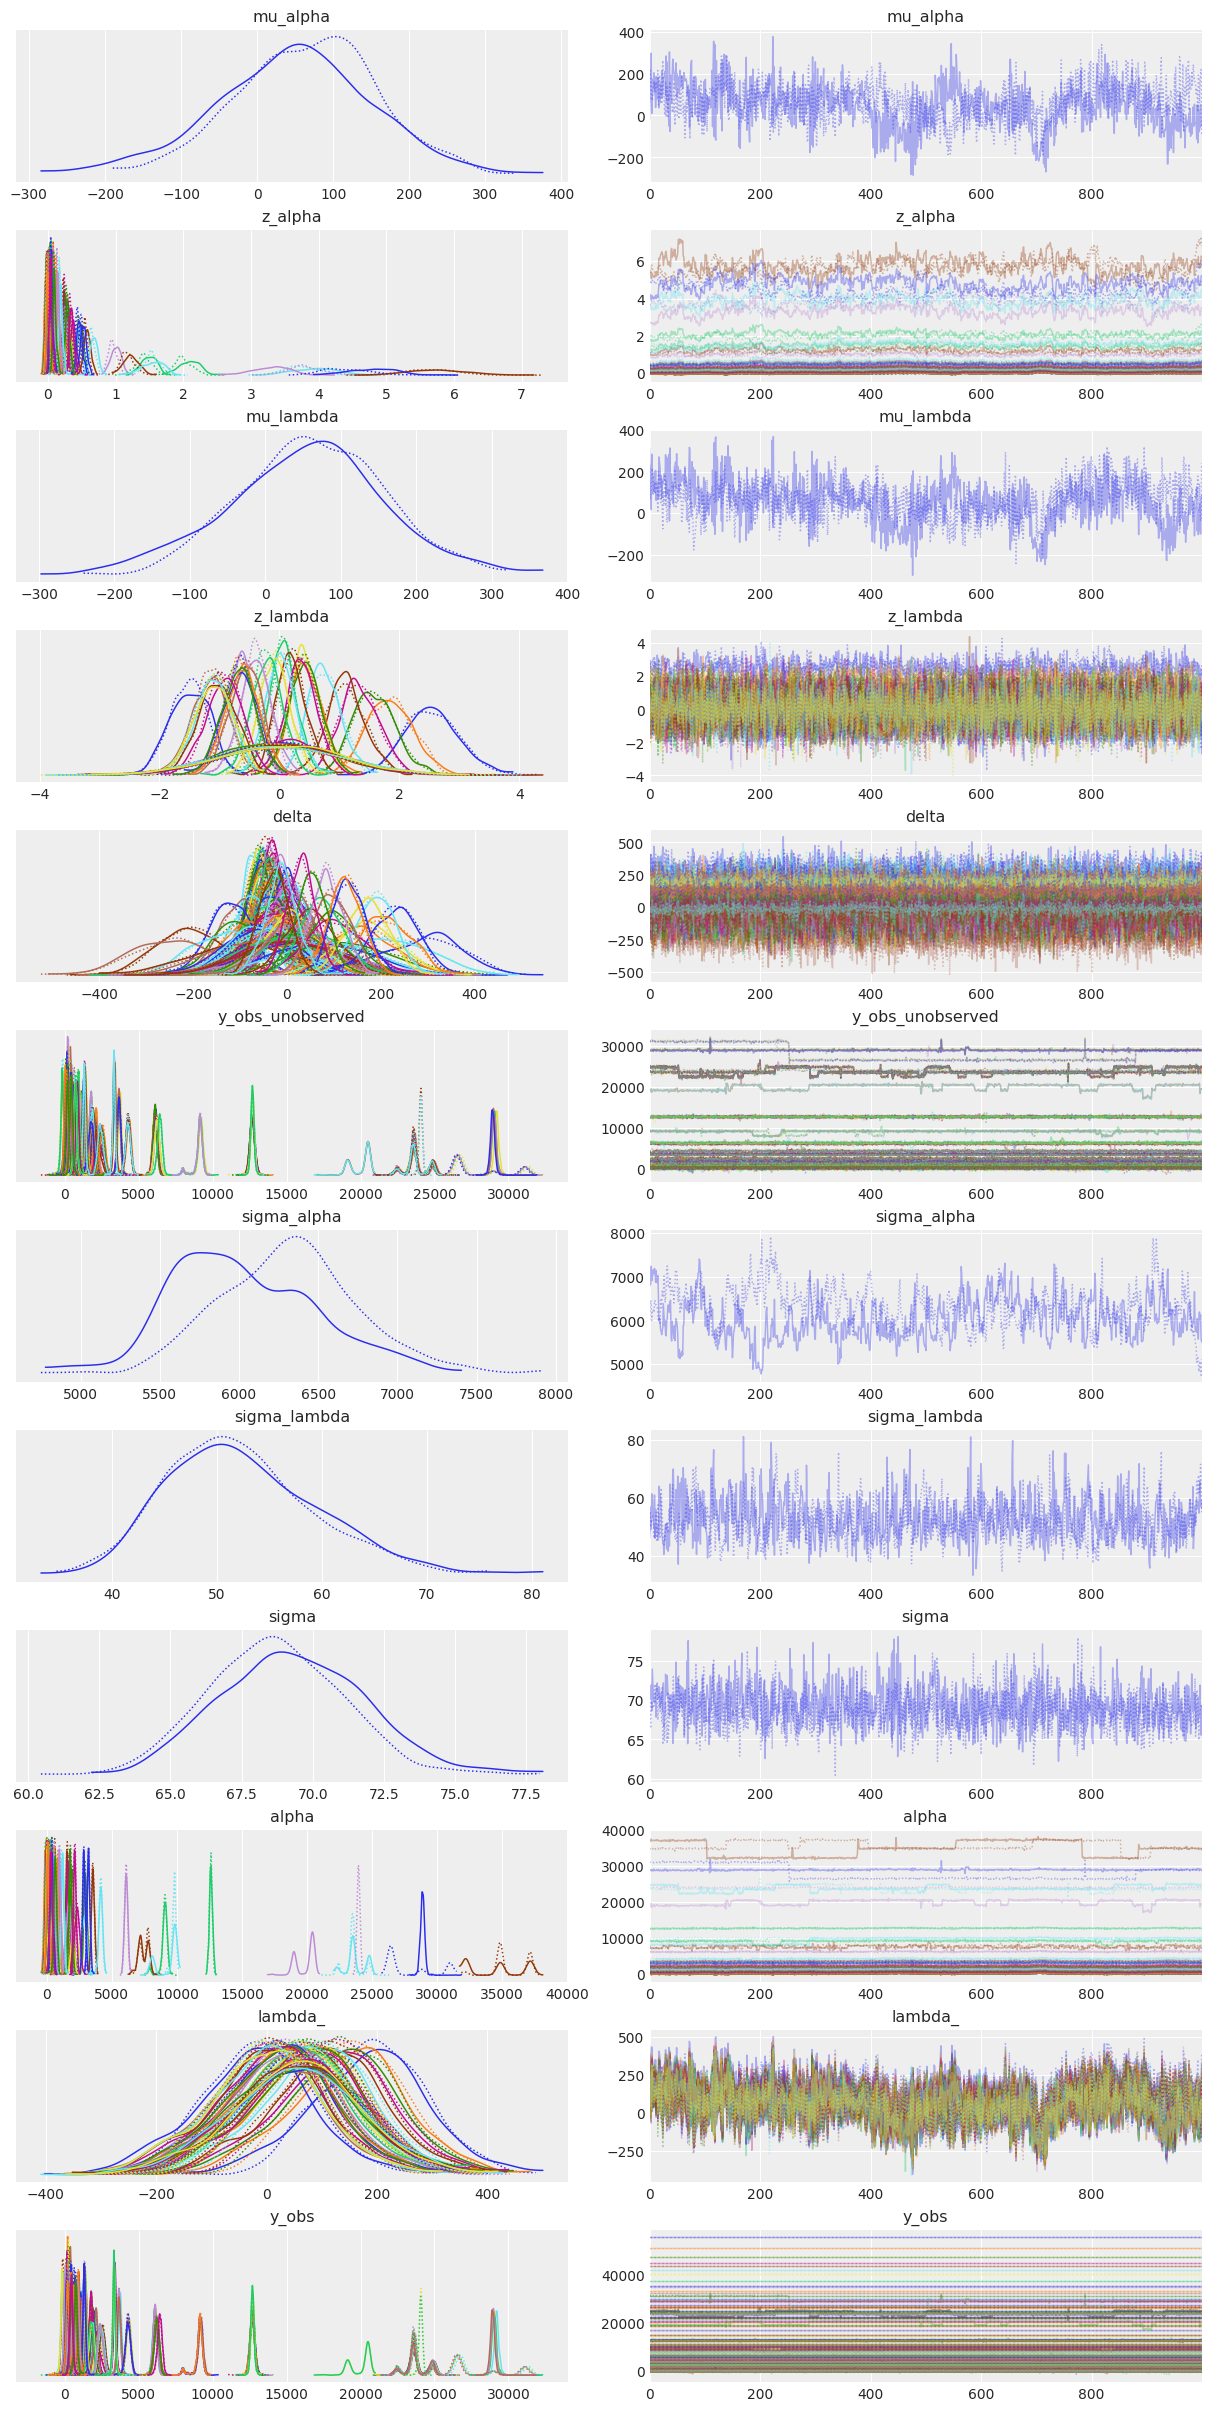

In [6]:
az.plot_trace(trace_dynamic_twfe_h);

In [18]:
with dynamic_twfe_h:
    pm.compute_log_likelihood(trace_dynamic_twfe_h)

az.waic(trace_dynamic_twfe_h)

Output()

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 2000 posterior samples and 1697 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -12113.89   188.72
p_waic      985.92        -

There has been a warning during the calculation. Please check the results.

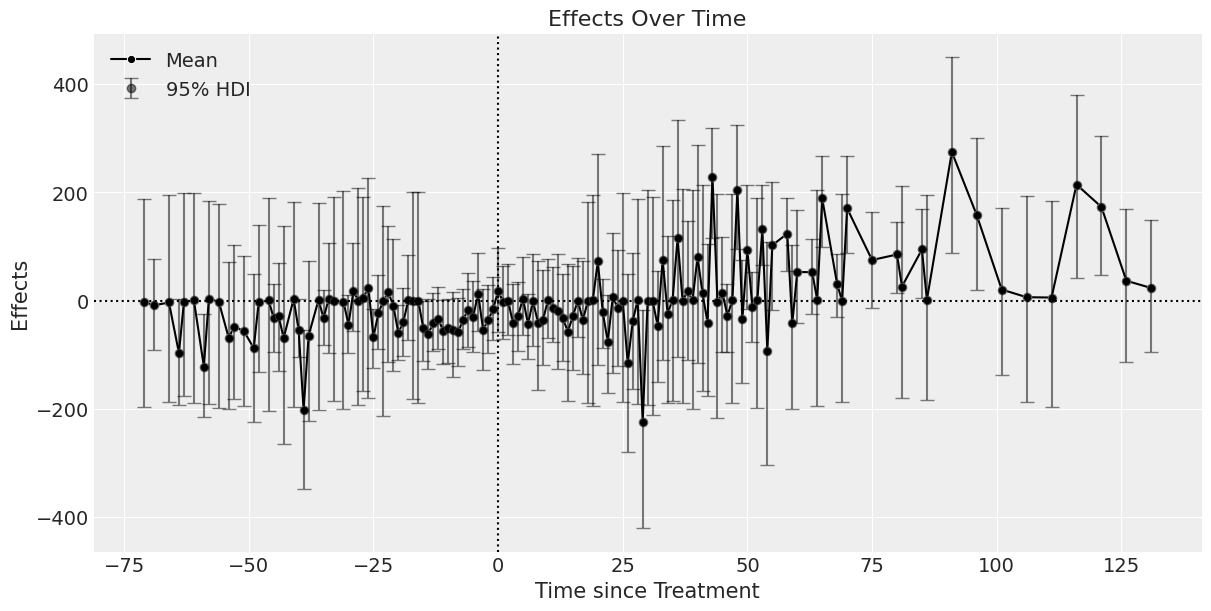

In [17]:
delta_df = get_delta_df(trace_dynamic_twfe_h)
plot_effects_over_time(delta_df)

## サンプリングの保存

In [42]:
az.to_netcdf(trace_dynamic_twfe, './mcmc_sample/dynamic_twfe.nc')
# az.to_netcdf(trace_dynamic_twfe_h, './sample/trace_dynamic_twfe_h.nc')

'./mcmc_sample/dynamic_twfe.nc'